In [301]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import astropy
import healpy as hp
import scipy.constants as spc
import time
import math

In [302]:
#import data
from astropy.io import fits
#put our own path here
path = "/Users/shiangyilin/21cmCosmology/cosmology/GLEAM_EGC_v2.fits"
hdul = fits.open(path)
df = pd.DataFrame(hdul[1].data)

In [315]:
class Catalog():
    
    def __init__(self, df, num, time = np.linspace(0, 2*np.pi, 768)):
        """
        modified from James and Daniel's code
        Initializes the Catalog and makes a new Pandas DataFrame containing the Right Ascension and Declination as well as all the fluxes
        
        Parameters:
        frame = Pandas DataFrame
        num = sample size
        time = time range array
        Creates: 
        self.frame as Pandas DataFrame type
        self.RA = right ascencion from J2000 in degrees as numpy.ndarray
        self.DEC = declination from J2000 in degrees as numpy.ndarray
        self.freqMHz = all possible freq in order as in df passed in
        self.time = time
        self.ALTAZ = array row size is the same as time array size, 
                        each each contains the array of [alt, az] 
                        for each freq in oder of self.freqMHz
        self.kAlphas = each row is a source, each row contains[k, alpha]
        
        Functions:
        getFluxAtFreq(self, freq) return an array of flux at Freq
        getAltazAtFreq(self, freq) return an array of [alt, az] at Freq
        """
        d = df.sort_values(by = "int_flux_076", ascending=False)
        d = d.dropna(axis = 0, how = "any")
        self.frame = d[[col for col in d.keys() if ((col=='RAJ2000' or col=='DEJ2000'or col[:9]=='int_flux_') 
                                                      and col!= 'int_flux_fit_200') and col != 'int_flux_wide']]
        self.frame = self.frame[:num]
       
        self.RA = np.asarray(self.frame.RAJ2000)[:num]
        self.DEC = np.asarray(self.frame.DEJ2000)[:num]
        """array of all possible freq"""
        self.freqMHz = [(int) (col[10:]) for col in self.frame.keys() if (col[:9]=='int_flux_')]
        self.time = time
        self.ALTAZ = [self.altaz(t) for t in time]
        self.kAlphas = self.kAlpha()
    
    def altaz(self, time, rad = False, lat = 37.875*np.pi/180):
        """
        from Max
        Calculates Altitude and Azimuth at given times, centered at HERA
        parameters: 
        time = lst in radian
        ra = Right ascension of the star in degrees or radians
        dec = Declination of the star in degrees or radians
        rad = True if RA and DEC are in radian or False if RA and DEC are in degree
        returns:
        Returns alt, and az all in radian
        """
        ra = self.RA
        dec = self.DEC
        PI = np.pi
        #Setting the latitude/longitude of HERA
        if rad == False:
            ra =ra * PI/180
            dec =dec * PI/180
        
        #Converts the LST to hour angle
        hour_array = np.mod((time - ra), 2*PI)
    
        #Calculates the Altitude and Azimuth
        alt = np.arcsin(np.sin(dec)*np.sin(lat)
                        + np.cos(dec)*np.cos(lat)*np.cos(hour_array))
        az = np.arctan2(np.sin(hour_array)*np.cos(dec),
                        np.cos(hour_array)*np.cos(dec)*np.sin(lat) - np.sin(dec)*np.cos(lat)) + PI
        return [alt, az]
    
    def getFluxAtFreq(self, freq):
        """return a flux array frequency FREQ"""
        assert np.where(self.freqMHz==freq)
        var = "int_flux_"
        if freq<100:
            var = var + '0' + str(freq)
        else:
            var = var + str(freq)
        return np.asarray(self.frame[var])
    
    def getAltazAtFreq(self, freq):
        """return an altaz array for at FREQ"""
        assert np.where(self.freqMHz==freq)
        index = 0
        currFreq = self.freqMHz[0]
        while currFreq != freq:
            index += 1 
            currFreq = self.freqMHz[index]
        return [[t[0][index], t[1][index]] for t in self.ALTAZ]
    
    def kAlpha(self):
        """return sourcesize * 2 array where each row is one source and the first column is k, second column is a"""
        frame_just_flux = np.array(self.frame[[col for col in self.frame.keys() if (col[:9]=='int_flux_')]])
        array = []
        for source in frame_just_flux:
            #find alpha
            flux1 = source[0]
            flux2 = source[1]
            v1 = self.freqMHz[0]
            v2 = self.freqMHz[1]
            a = math.log(flux1/flux2, v2/v1)
            #find k
            k = flux1 / math.pow(v1, a)
            array.append([k, a])
        return array
    
        def position_vector(self, alt, az):
        '''
        Calculates the position vector to a source in the sky 
        Parameters: 
        alt = the altitude of the source from the horizon, given in radians
        az  = the angle from north, moving towards the east, given in radians
        Returns:
        vector in cartesian coordinates [x,y,z] as a numpy.ndarray
        '''
        x = np.cos(alt) * np.cos(az)
        y = np.cos(alt) * np.sin(az)
        z = np.sin(alt)
        vector = np.asarray([x,y,z])
        return vector
    
    
    
    #def phase(s):
        

In [304]:
data = Catalog(df, np.linspace(0,np.pi, 100))
data.frame

,RAJ2000,DEJ2000,int_flux_076,int_flux_084,int_flux_092,int_flux_099,int_flux_107,int_flux_115,int_flux_122,int_flux_130,...,int_flux_158,int_flux_166,int_flux_174,int_flux_181,int_flux_189,int_flux_197,int_flux_204,int_flux_212,int_flux_220,int_flux_227
91300,41.063450,-33.547829,0.000006,0.067081,0.019308,0.042207,0.059715,0.054510,0.029013,0.015418,...,0.003149,0.021491,0.045286,0.023692,0.034019,0.020425,0.034059,0.018532,0.006835,0.038853
7010,326.466248,-51.320374,0.000025,0.028464,0.098461,0.019422,0.040728,0.023289,0.052323,0.067068,...,0.053315,0.052220,0.028043,0.053764,0.029839,0.059060,0.082695,0.046018,0.044762,0.050638
75317,60.643295,-44.959244,0.000026,0.155249,0.104952,0.006164,0.114957,0.022434,0.037359,0.088222,...,0.027273,0.064911,0.079585,0.036423,0.019032,0.040617,0.062467,0.041800,0.047662,0.066020
105034,43.731094,-26.103849,0.000027,0.102409,0.017543,0.012834,0.044740,0.005923,0.042037,0.072302,...,0.049902,0.034772,0.004826,0.059591,0.102778,0.040360,0.049681,0.061734,0.060506,0.063236
82818,91.312416,-36.585419,0.000031,0.009039,0.076827,0.032007,0.111158,0.066670,0.079588,0.099116,...,0.056539,0.036246,0.024090,0.039374,0.057235,0.071210,0.010420,0.042774,0.049225,0.052060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237415,187.275879,2.047744,139.836960,134.327698,124.787437,119.481178,112.081902,106.930702,102.557899,98.701263,...,88.066742,84.869179,79.372368,76.192551,75.515564,73.872574,75.144600,75.161293,73.069115,72.682610
30470,333.606415,-17.027868,147.306534,132.358398,123.509354,113.445084,107.333900,100.573502,94.528175,88.371529,...,72.966576,69.372597,65.693535,63.250198,60.242313,58.006725,55.797695,54.222332,52.211391,50.322487
266765,293.988464,-46.344551,151.090759,141.014725,128.626572,116.566994,94.208466,90.589989,83.974586,76.740700,...,60.680248,57.082157,63.611805,63.954525,66.460060,64.467476,61.751926,59.734615,56.471710,54.479408
168281,69.269493,29.669428,352.720367,335.537567,306.668793,287.555603,277.505188,266.713013,252.885208,245.002808,...,219.758392,213.660080,198.113525,195.331558,192.729980,182.604630,182.176056,177.663849,178.486176,168.604797


In [305]:
def test_flux(freq, k, alpha):
    return k*freq**alpha


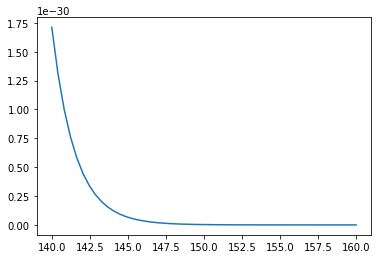

In [307]:
k_alphas = data.kAlpha()
freq = np.linspace(140, 160, 50)
test = test_flux(freq, k_alphas[0][0], k_alphas[0][1])
plt.figure()
plt.plot(freq, test)


In [208]:
data.getFreqFlux(76, 100)

int_flux_076


array([6.33388345e-06, 2.54014558e-05, 2.60452016e-05, 2.71018380e-05,
       3.09330717e-05, 3.56644268e-05, 3.77505967e-05, 3.86940337e-05,
       5.85987509e-05, 6.48602945e-05, 7.02833713e-05, 7.49455794e-05,
       7.79461334e-05, 8.07416727e-05, 8.41916190e-05, 8.60460204e-05,
       8.69536743e-05, 9.19996382e-05, 9.68151362e-05, 1.10213216e-04,
       1.17775038e-04, 1.18733122e-04, 1.22288679e-04, 1.28476968e-04,
       1.31539753e-04, 1.31899855e-04, 1.33349953e-04, 1.36434945e-04,
       1.44170612e-04, 1.52227702e-04, 1.52481603e-04, 1.54911075e-04,
       1.59176372e-04, 1.61144897e-04, 1.61314354e-04, 1.63803241e-04,
       1.67035047e-04, 1.71330234e-04, 1.73870096e-04, 1.76101516e-04,
       1.89116225e-04, 1.91748608e-04, 1.99649192e-04, 2.14509622e-04,
       2.29461642e-04, 2.33926039e-04, 2.42081223e-04, 2.44620896e-04,
       2.48994067e-04, 2.63473543e-04, 2.75782222e-04, 2.77884770e-04,
       2.80965236e-04, 2.81496381e-04, 2.81828077e-04, 2.83529953e-04,
      

In [312]:
data.getFreqAltaz(76)[:20]

[[0.15738423, 2.5540433],
 [0.17102939, 2.5770078],
 [0.18418482, 2.6003172],
 [0.19683605, 2.6239698],
 [0.208969, 2.647962],
 [0.22056884, 2.6722882],
 [0.23162165, 2.6969428],
 [0.24211325, 2.721917],
 [0.25203007, 2.7472024],
 [0.26135856, 2.7727878],
 [0.270086, 2.7986617],
 [0.27819973, 2.8248098],
 [0.28568807, 2.8512173],
 [0.29253957, 2.8778675],
 [0.29874408, 2.9047425],
 [0.30429146, 2.9318228],
 [0.30917326, 2.959088],
 [0.31338134, 2.9865162],
 [0.3169089, 3.0140843],
 [0.31975013, 3.0417695]]

In [210]:
class Antenna():
    nside= 32 
    npix = hp.nside2npix(nside)
    
    def beam(model):
        if (model == 'one'):
            return 1
        
        elif (model == 'gaussian'):
            return getGaussian(npix, 0, 1)

        elif (model == "airy"):
            return getAiry()
        return
            
            
    def getGaussian(length, mean, std):
        x = np.arange(0,length)
        function = (1/(std*(2*np.pi)**.5))*np.exp(-.5*((x-mean)/std)**2)
        return function
    
    def getAiry(freq = 100, co_altitude = 10, aperture = 6):
        """return an airy funtion
        J1 is the bessel function of the first kind of order 1
        aperture radius is 6m
        still working on bessel
        """
        a = aperture
        theta = co_altitude
        k = 2 * math.pi * freq /c
        k_a_sin = k * a * math.sin(theta)            
        j1 = sp.special.jv(1, k_a_sin)
        return (2 * j1 / (k_a_sin))**2
            
    def phase(b, s):
        assert b.lenght == s.length
        
    def graph():

SyntaxError: unexpected EOF while parsing (<ipython-input-210-6c3b1a9d21e5>, line 38)